In [5]:
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt

from train_finn import main

In [6]:
train_data_dir = Path("../data/synthetic_data/retardation_freundlich").resolve()
model, t_train, c_train = main(
    y_train_path=train_data_dir / "c_train.npy",
    output_dir=Path("../data_out").resolve(),
    train_split_idx=51,
    seed=98275984,
    skip=0,
    max_epochs=100,
    c_field_seed=3487560,
)

Loading data from /Users/r/Documents/stud/ss24/finnpinn/data/synthetic_data/retardation_freundlich/c_train.npy
Saving files to /Users/r/Documents/stud/ss24/finnpinn/data_out
Train split index: 51
Skip: 0
Max epochs: 100
Seed: 98275984
C-Loss Seed: None
t_train.shape=torch.Size([51])
Training: Epoch [2/100], Training Loss: 3.0168, Runtime: 17.5533 secs
Training: Epoch [3/100], Training Loss: 1.0799, Runtime: 15.8443 secs
Training: Epoch [4/100], Training Loss: 0.1442, Runtime: 14.7691 secs
Training: Epoch [5/100], Training Loss: 0.0336, Runtime: 13.3831 secs
Training: Epoch [6/100], Training Loss: 0.0320, Runtime: 12.9076 secs
Training: Epoch [7/100], Training Loss: 0.0320, Runtime: 12.9295 secs
Training: Epoch [8/100], Training Loss: 0.0319, Runtime: 13.0388 secs
Training: Epoch [9/100], Training Loss: 0.0292, Runtime: 12.9885 secs
Training: Epoch [10/100], Training Loss: 0.0108, Runtime: 12.9318 secs
Training: Epoch [11/100], Training Loss: 0.0050, Runtime: 13.5880 secs
Training: Epoc

# Generate residual datasets

In [7]:
# create datasets from the residuals (positive and negative)
# TODO: Should I only do training data or full data?
# Probably on training data since I later want to show the generalization ability
model.eval()
with torch.no_grad():
    c_predictions = model(t_train)
c_predictions = c_predictions.detach().cpu().numpy()
residuals = c_train.detach().cpu().numpy() - c_predictions

NOISE_SIGMA = 0# 8e-4  # 4e-4 is the lowest I can go since otherwise there will be too large gaps
print(f"{residuals.min():.2e}, {residuals.max():.2e}, {residuals.mean():.2e}, {np.median(np.abs(residuals)):.2e}")

-2.11e-03, 1.92e-03, -5.32e-05, 8.15e-05


In [8]:
# add noise to predictions to make the data points for the pos/neg residuals more uniform
c_predictions += np.random.normal(0, NOISE_SIGMA, c_predictions.shape)
np.save("../data_out/c_predictions.npy", c_predictions)
residuals = c_train - c_predictions
residuals.shape

torch.Size([51, 2, 26, 1])

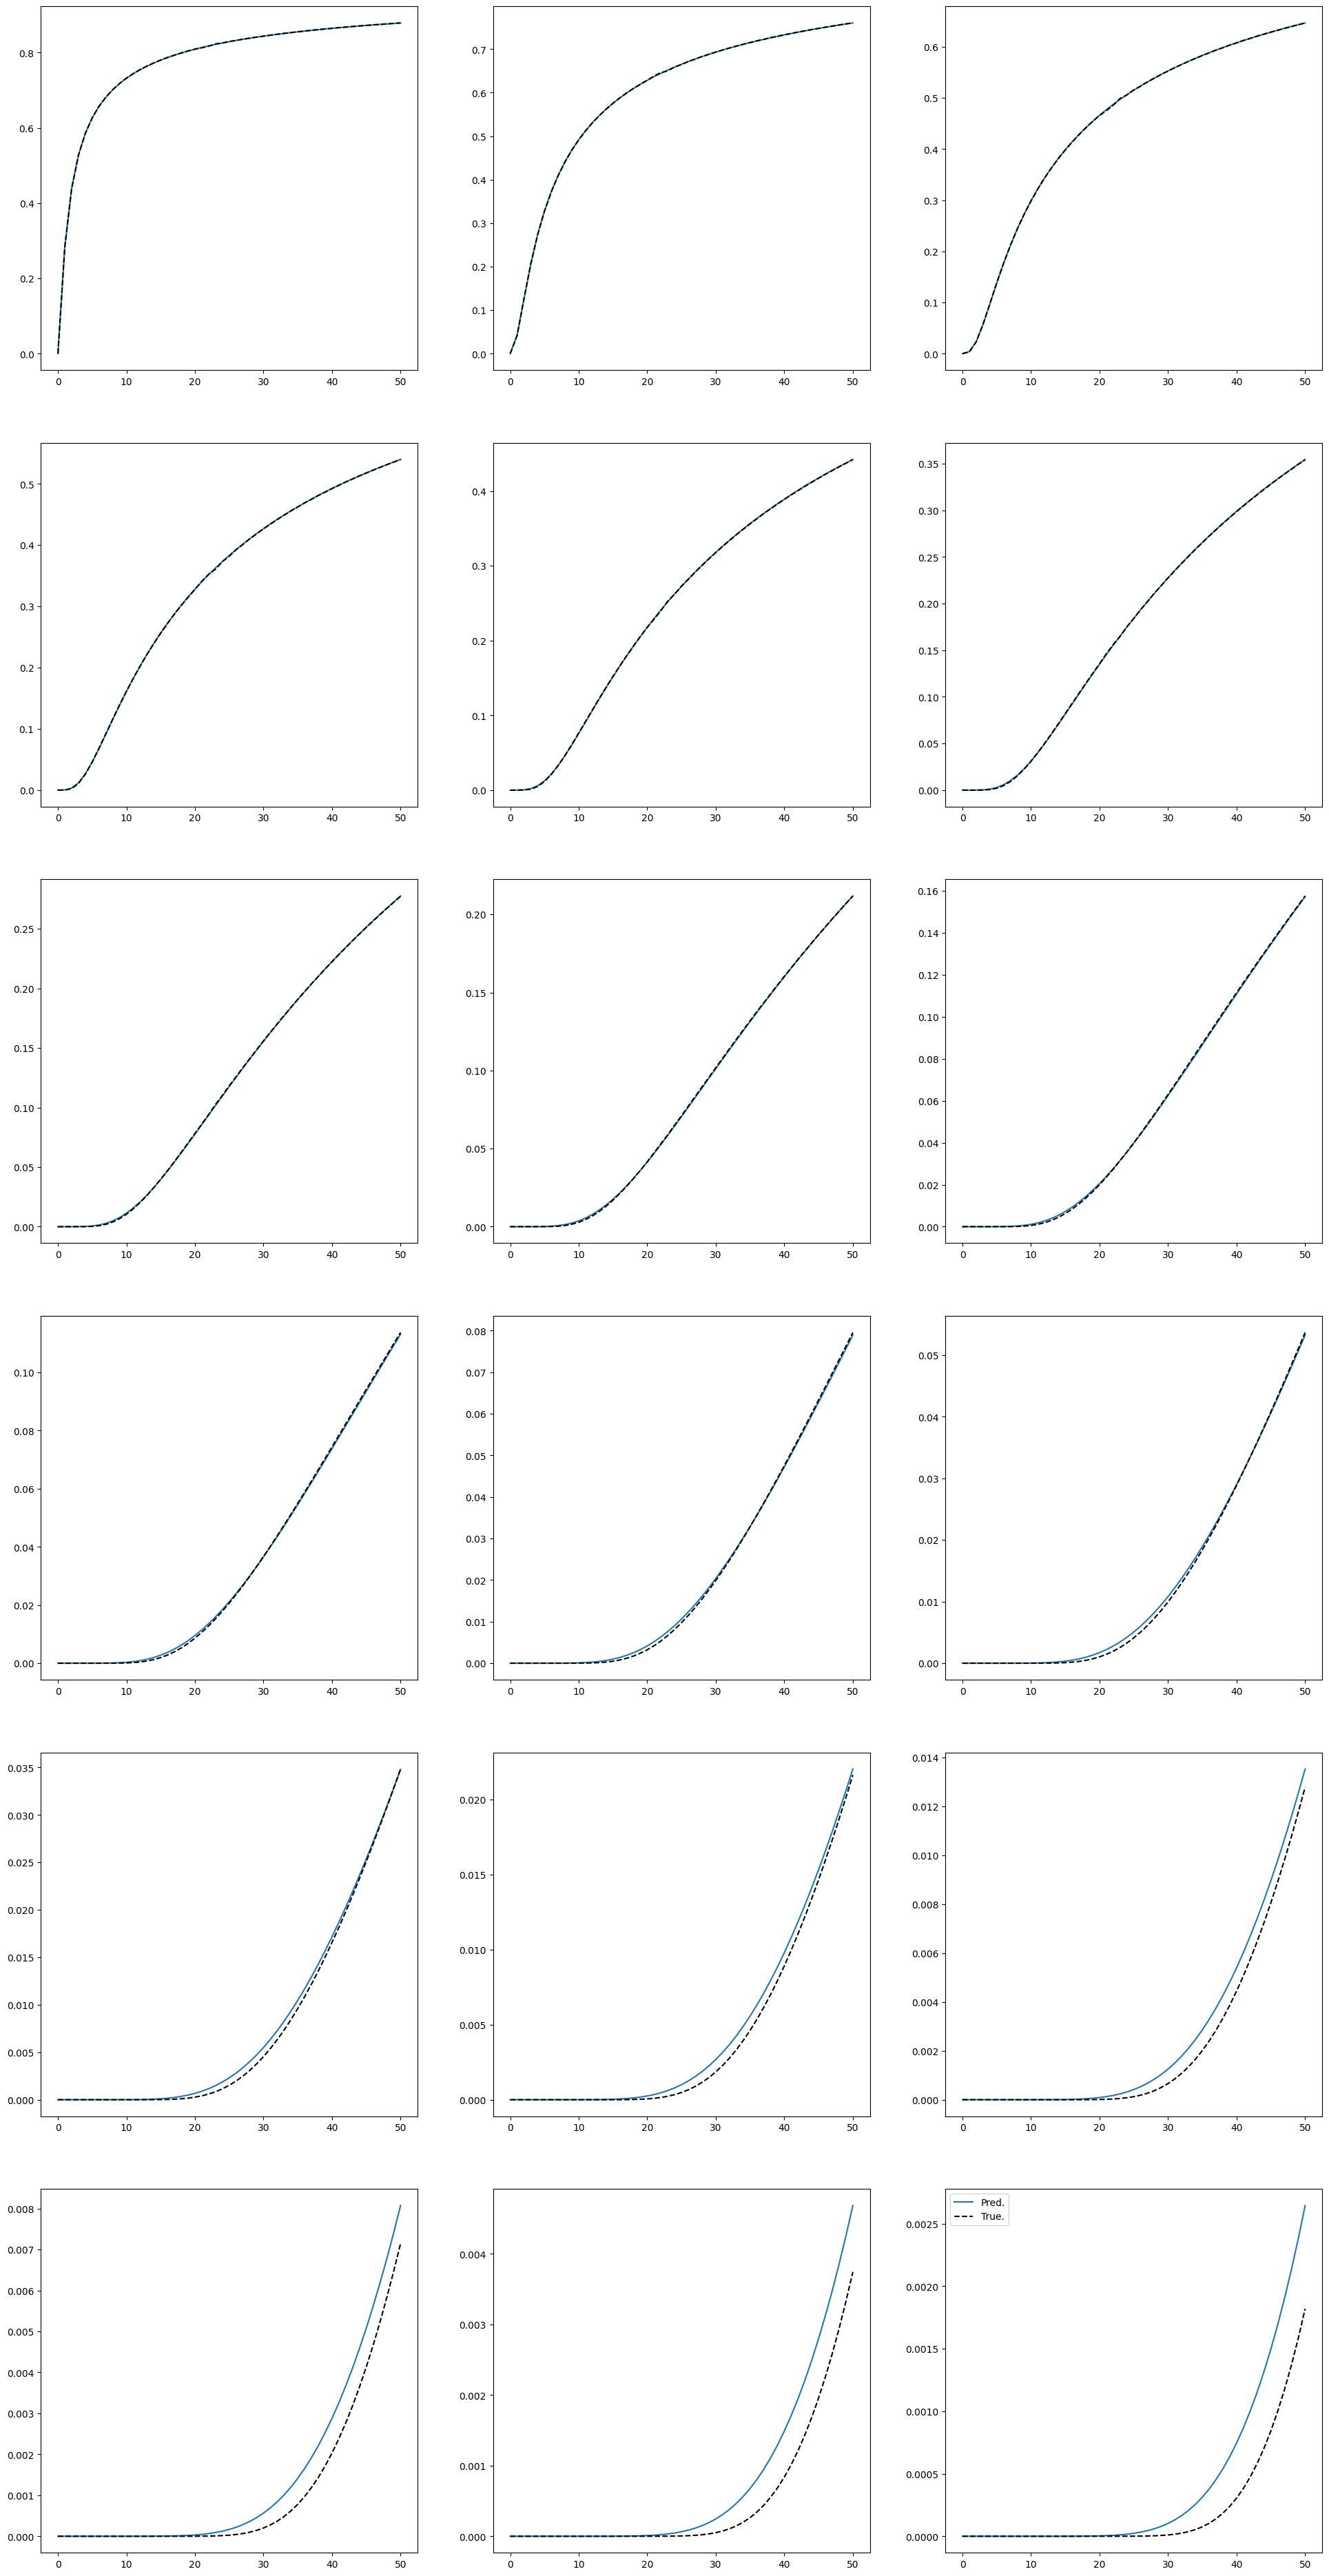

In [9]:
from math import ceil
ncols = 3
nrows = ceil(26/5)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8*ncols,8*nrows))
axs = axs.flatten()
for i, ax in zip(range(c_train.shape[2]), axs):
    ax.plot(c_predictions[:, 0, i, 0], label="Pred.")
    ax.plot(c_train[:, 0, i, 0], "k--", label="True.")
plt.legend()
plt.show()

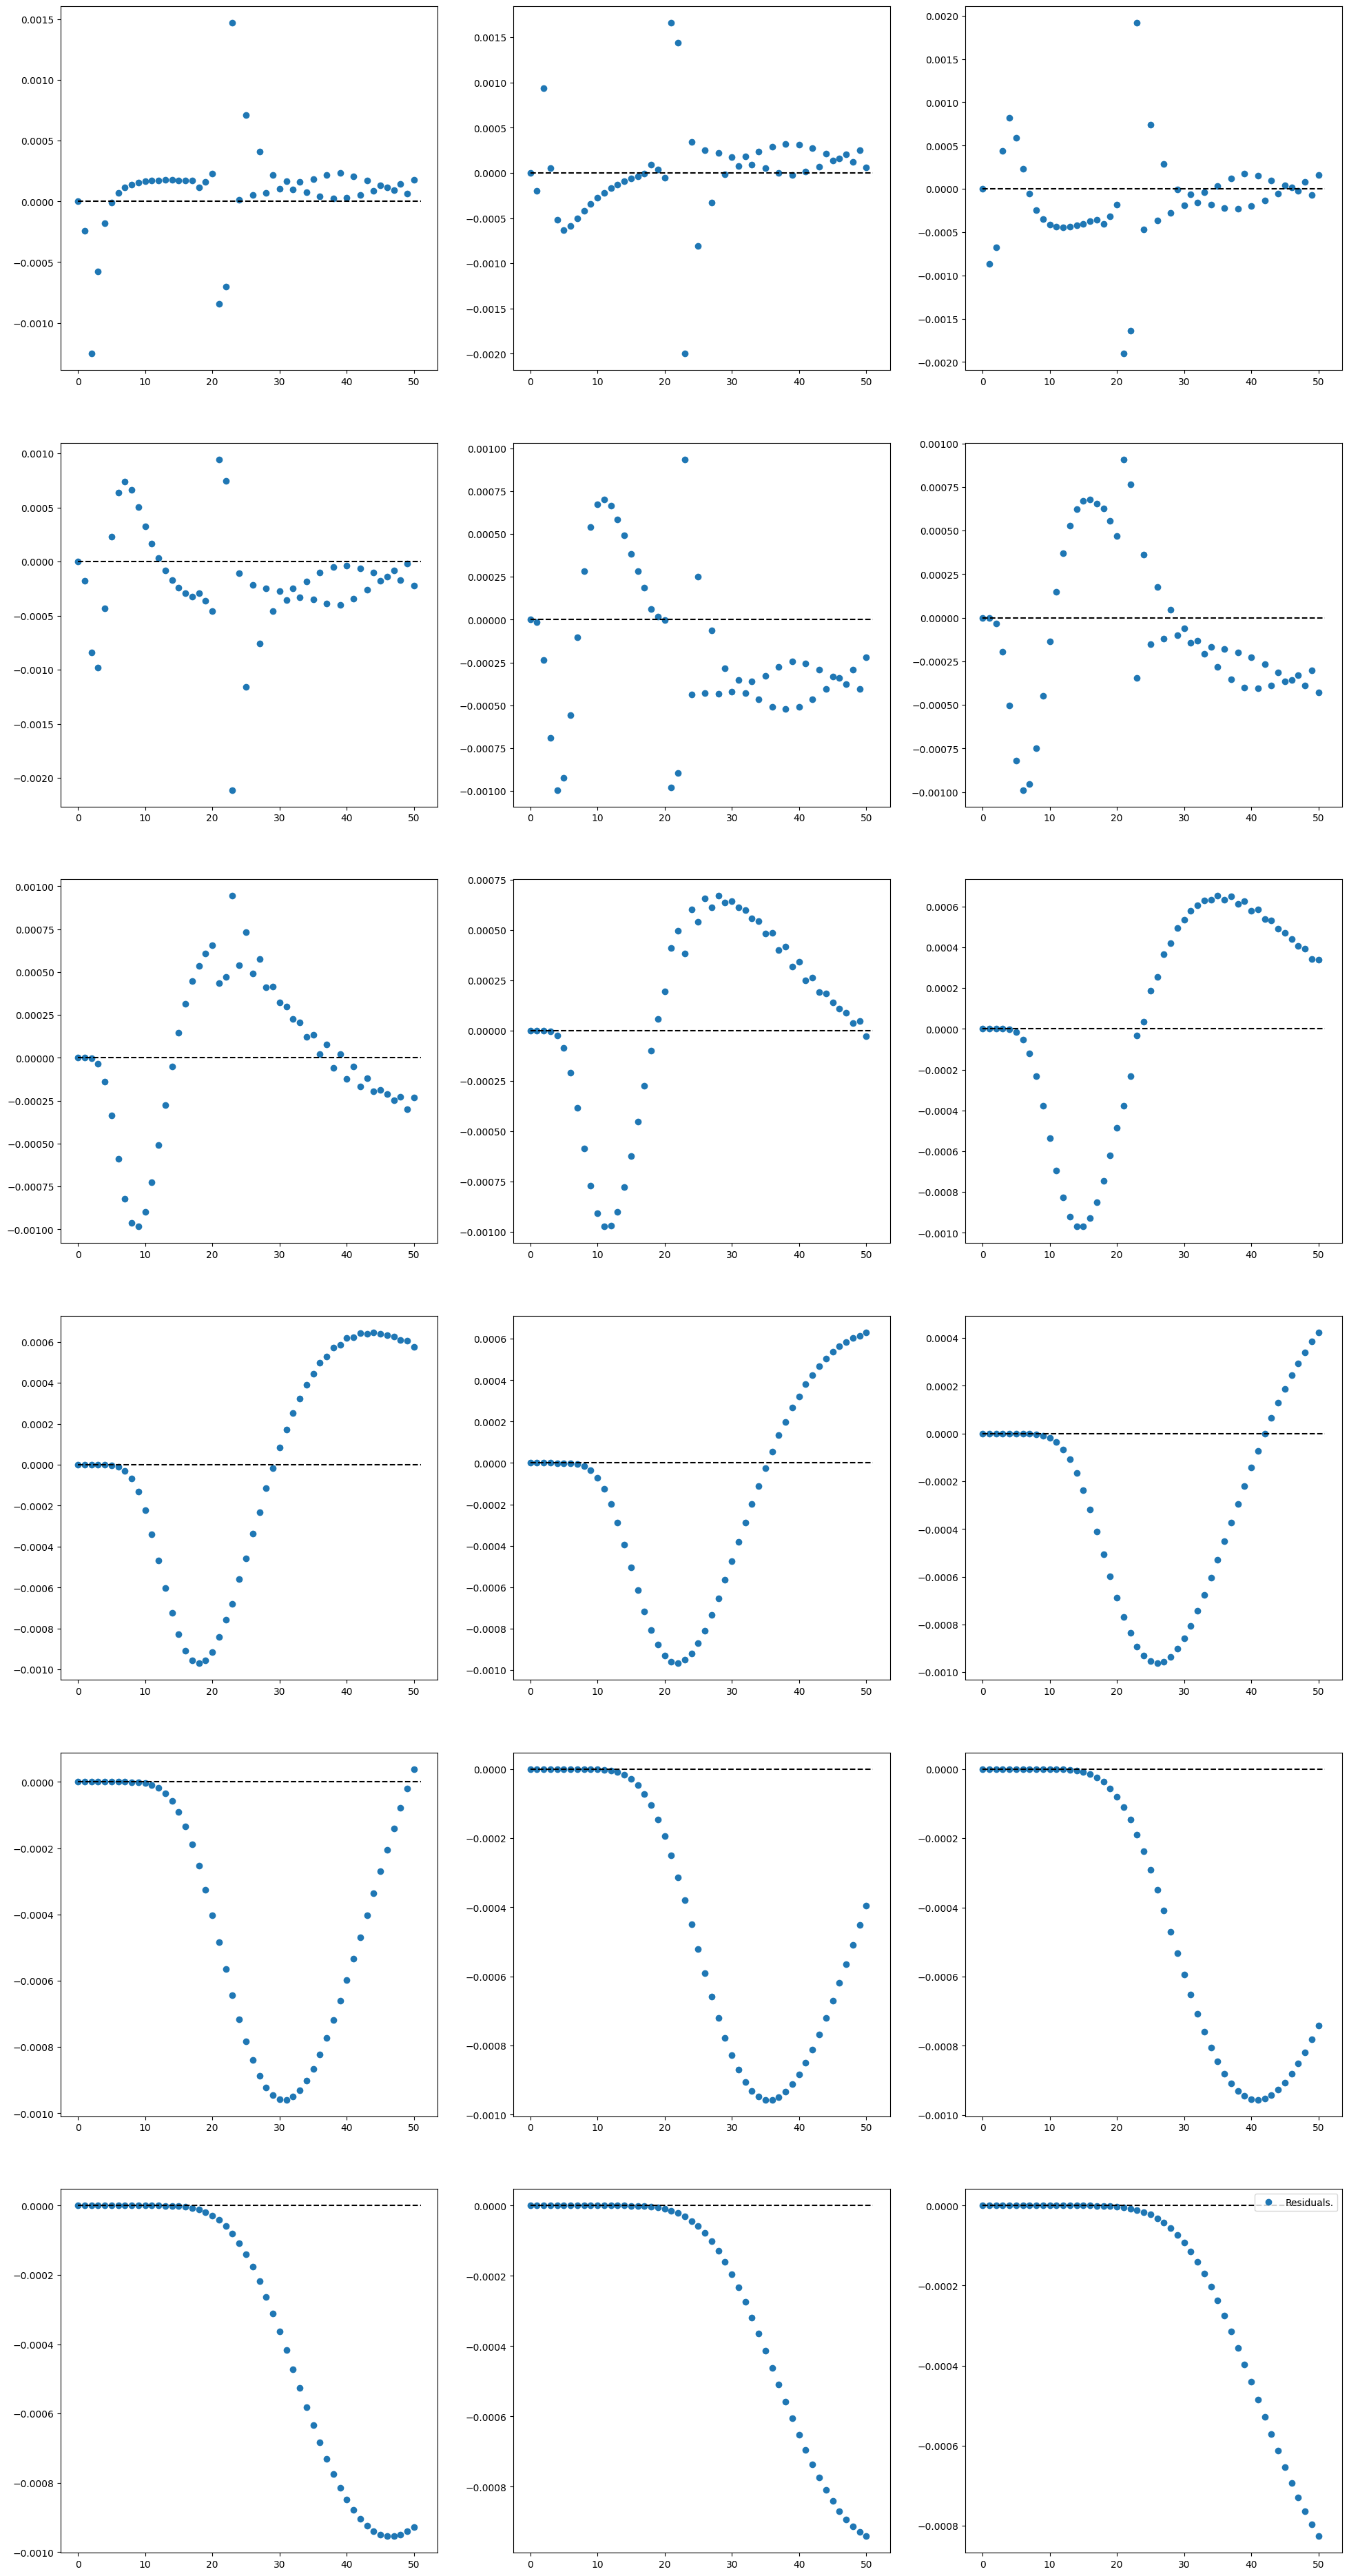

In [10]:
from math import ceil
ncols = 3
nrows = ceil(26/5)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8*ncols,8*nrows))
axs = axs.flatten()
for i, ax in zip(range(c_train.shape[2]), axs):
    ax.plot(residuals[:, 0, i, 0], "o", label="Residuals.")
    ax.hlines(0, 0, c_train.shape[0], color="k", linestyle="--")
plt.legend()
plt.show()

### Predictions without Noise

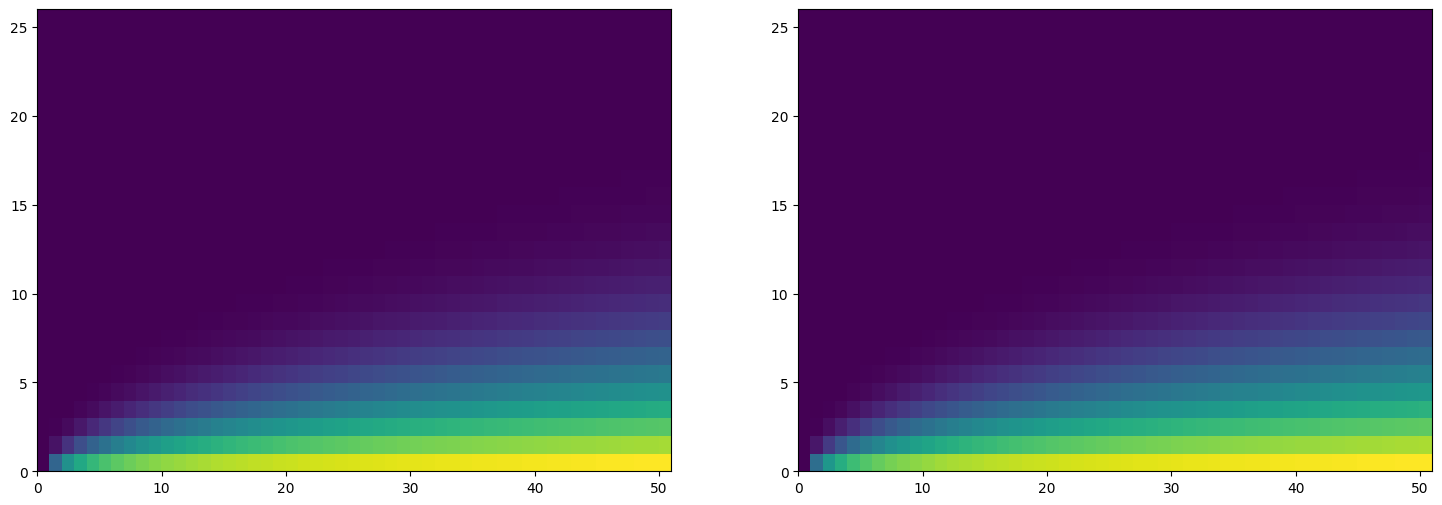

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
ax1.pcolor(c_predictions[:, 0, :, 0].T)
ax2.pcolor(c_predictions[:, 1, :, 0].T)
plt.show()

### Residuals without Noise

tensor(0.0021)


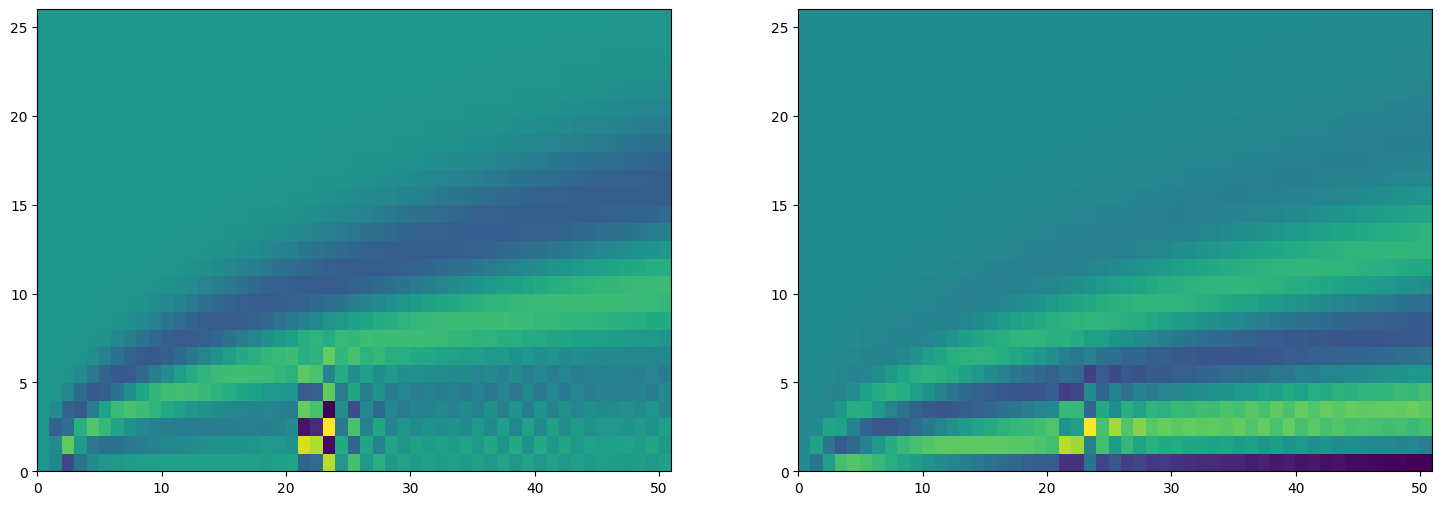

In [12]:
print((c_train - c_predictions).abs().max())
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
ax1.pcolor(((c_train - c_predictions)[:, 0, :, 0]).T)
ax2.pcolor(((c_train - c_predictions)[:, 1, :, 0]).T)
plt.show()

## Results with Noise

### Residual Sign

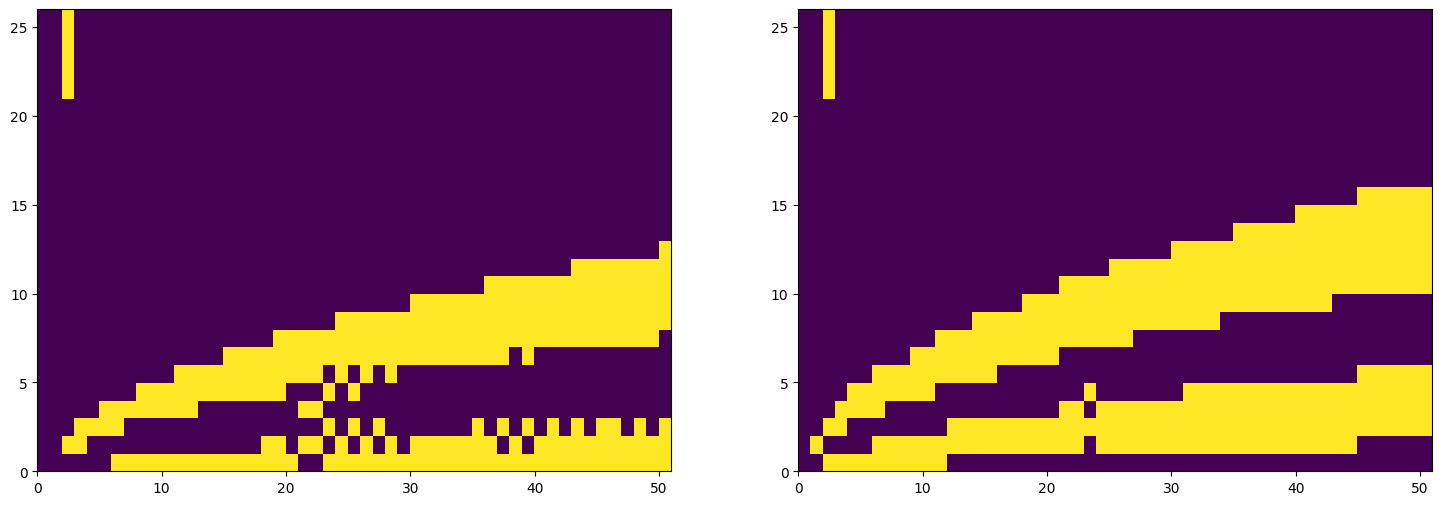

In [13]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
ax1.pcolor((residuals[:, 0, :, 0] > 0).T)
ax2.pcolor((residuals[:, 1, :, 0] > 0).T)
plt.show()

### Residuals

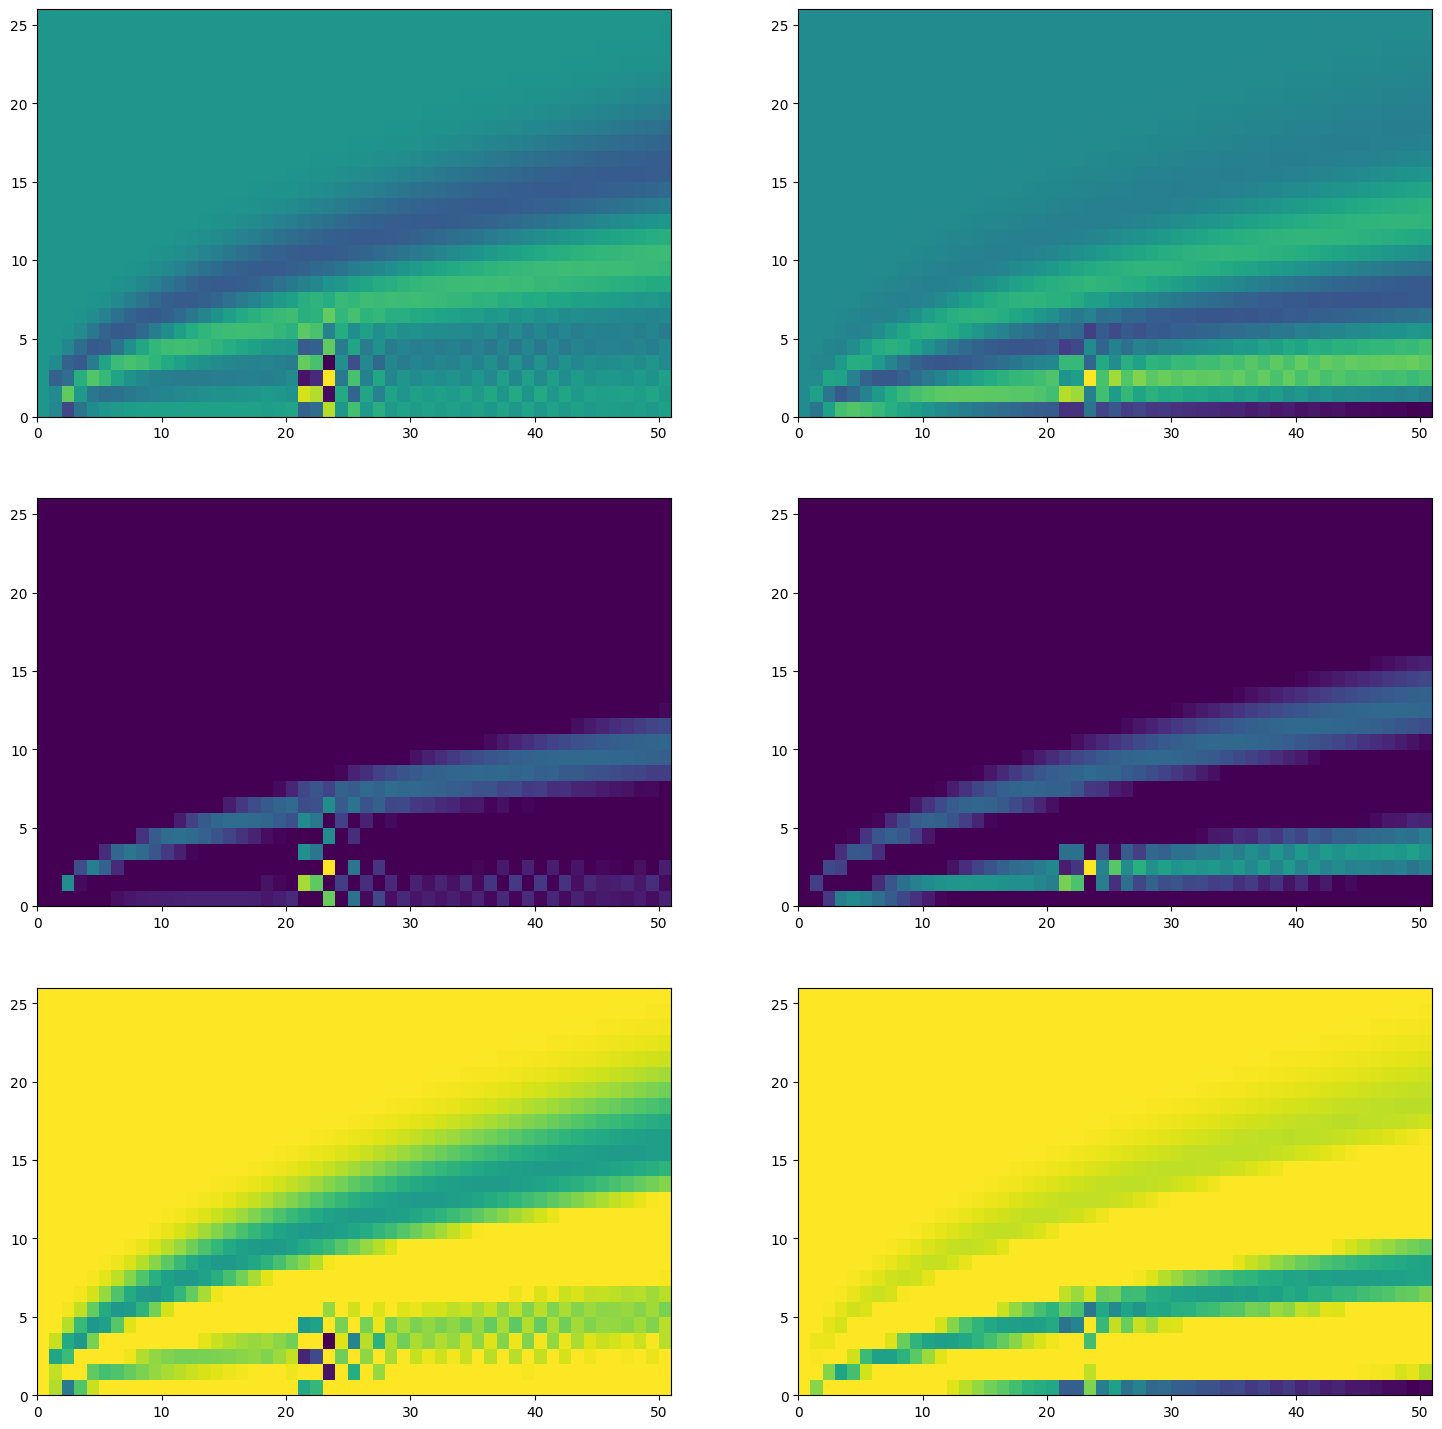

In [14]:
fig, axs = plt.subplots(nrows = 3, ncols=2, figsize=(18,18))
axs[0, 0].pcolor((residuals[:, 0, :, 0]).T)
axs[0, 1].pcolor((residuals[:, 1, :, 0]).T)

axs[1, 0].pcolor(np.clip(residuals[:, 0, :, 0], 0, 1e100).T)
axs[1, 1].pcolor(np.clip(residuals[:, 1, :, 0], 0, 1e100).T)

axs[2, 0].pcolor(np.clip(residuals[:, 0, :, 0], -1e100, 0).T)
axs[2, 1].pcolor(np.clip(residuals[:, 1, :, 0], -1e100, 0).T)
plt.show()

In [15]:
median_diss = torch.median(residuals[:, 0, ...])
median_tot = torch.median(residuals[:, 1, ...])
residuals[:, 0, ...] -= median_diss
residuals[:, 1, ...] -= median_tot

np.save("../data_out/residual_medians.npy", np.array([median_diss, median_tot]))

In [16]:
is_res_pos = residuals > 0
is_res_pos.shape

torch.Size([51, 2, 26, 1])

In [17]:
print(np.count_nonzero(is_res_pos))
print(np.count_nonzero(~is_res_pos))
print()
print(np.count_nonzero(is_res_pos[:, 0, ...]))
print(np.count_nonzero(~is_res_pos[:, 0, ...]))
print()
print(np.count_nonzero(is_res_pos[:, 1, ...]))
print(np.count_nonzero(~is_res_pos[:, 1, ...]))

1326
1326

663
663

663
663


In [18]:
import params

In [19]:
t = t_train
x = torch.linspace(0.0, params.X, params.Nx)
if not isinstance(t, np.ndarray):
    t = t.numpy()
    x = x.numpy()

X_pos = ([], [])
X_neg = ([], [])
Y_pos = ([], [])
Y_neg = ([], [])
X_pos_test = ([], [])
X_neg_test = ([], [])
for i in range(residuals.size(0)):
    for j in range(residuals.size(2)):
        for k in range(residuals.size(1)):
            if is_res_pos[i, k, j, 0]:
                X_pos[k].append([t[i], x[j]])
                X_neg_test[k].append([t[i], x[j]])
                Y_pos[k].append(residuals[i, k, j, 0])
            else:
                X_neg[k].append([t[i], x[j]])
                X_pos_test[k].append([t[i], x[j]])
                Y_neg[k].append(residuals[i, k, j, 0])

In [20]:
output_path = Path("../data_out/residual_training_data").resolve()
output_path.mkdir(exist_ok=True, parents=True)
for k, suffix in enumerate(["diss", "tot"]):
    np.save(output_path / f"X_pos_train_{suffix}.npy", np.array(X_pos[k]))
    np.save(output_path / f"X_neg_train_{suffix}.npy", np.array(X_neg[k]))
    np.save(output_path / f"Y_pos_train_{suffix}.npy", np.array(Y_pos[k]))
    np.save(output_path / f"Y_neg_train_{suffix}.npy", np.array(Y_neg[k]))

    np.save(output_path / f"X_pos_test_{suffix}.npy", np.array(X_pos_test[k]))
    np.save(output_path / f"X_neg_test_{suffix}.npy", np.array(X_neg_test[k]))

# Analyze predictions

In [21]:
from common import plot_c, plot_c_timeseries, plot_c_spaceseries

In [22]:
residuals.abs().max()

tensor(0.0021)

In [23]:
print(c_predictions.shape)

(51, 2, 26, 1)


### Predictions with Noise

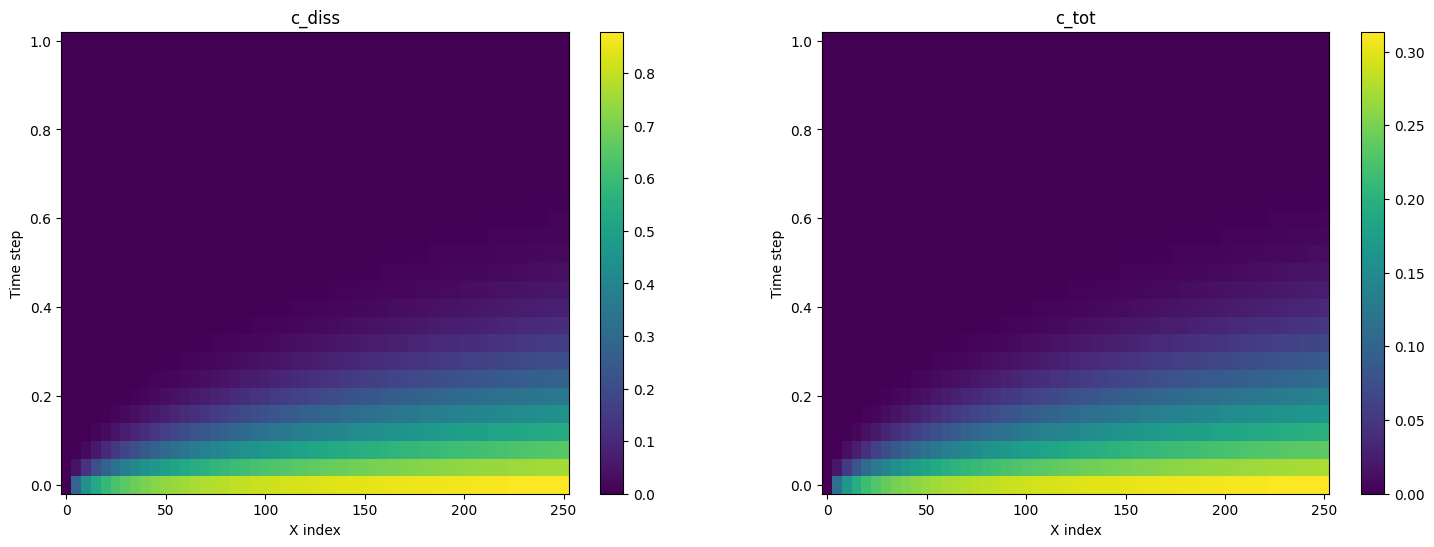

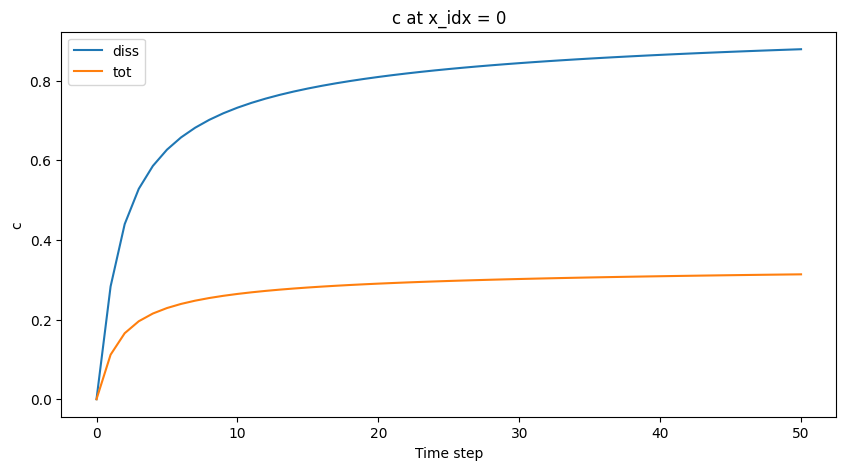

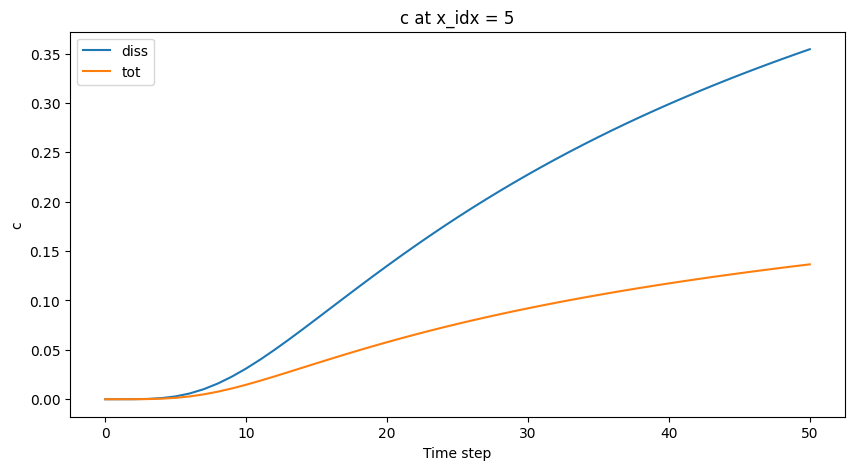

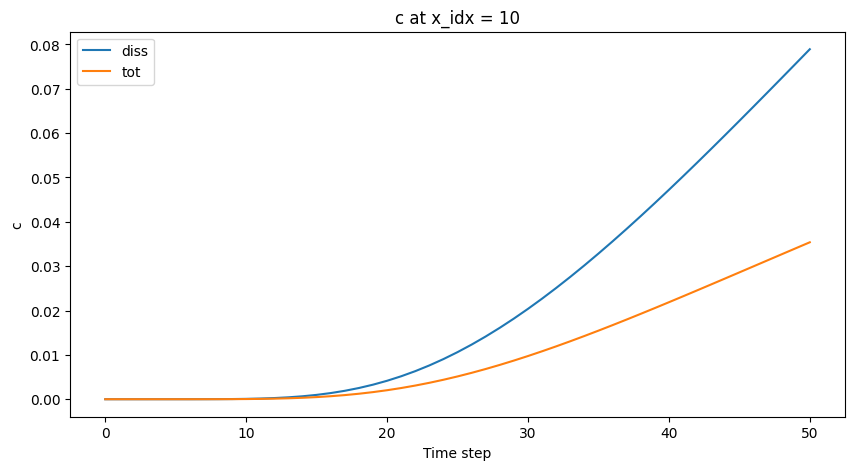

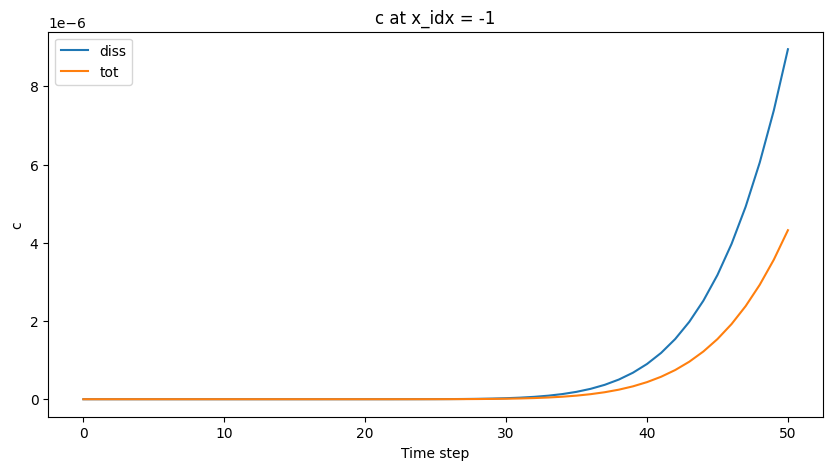

In [24]:
X, T = np.meshgrid(x, t_train)
plot_c(t=T, x=X, c=c_predictions[...,0])
plot_c_timeseries(c_predictions[...,0], x_idx=0)
plot_c_timeseries(c_predictions[...,0], x_idx=5)
plot_c_timeseries(c_predictions[...,0], x_idx=10)
plot_c_timeseries(c_predictions[...,0], x_idx=-1)
plt.show()

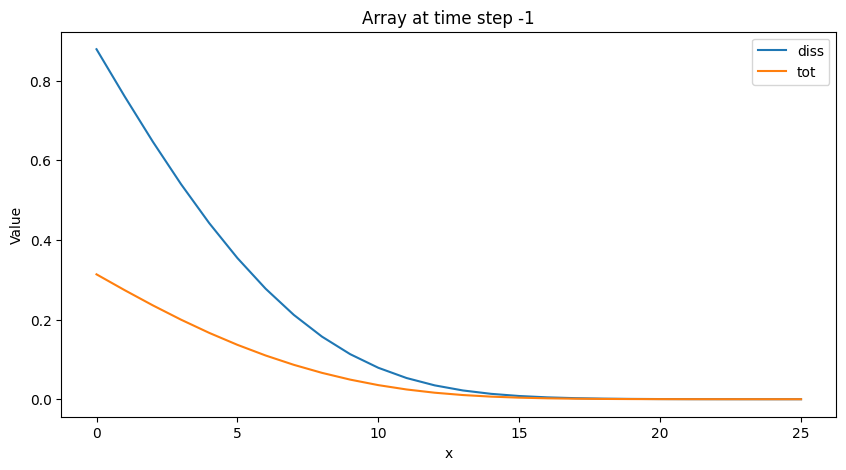

In [25]:
plot_c_spaceseries(c_predictions[...,0], t_idx=-1)

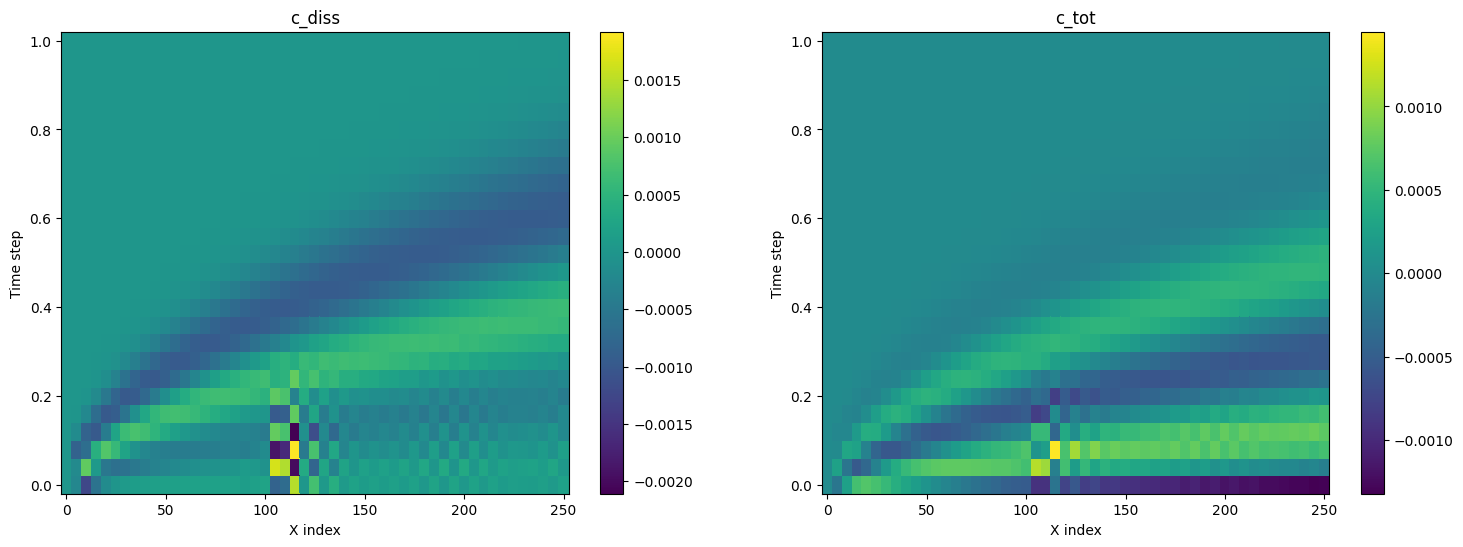

In [26]:
plot_c(t=T, x=X, c=residuals[...,0])

# Training Data

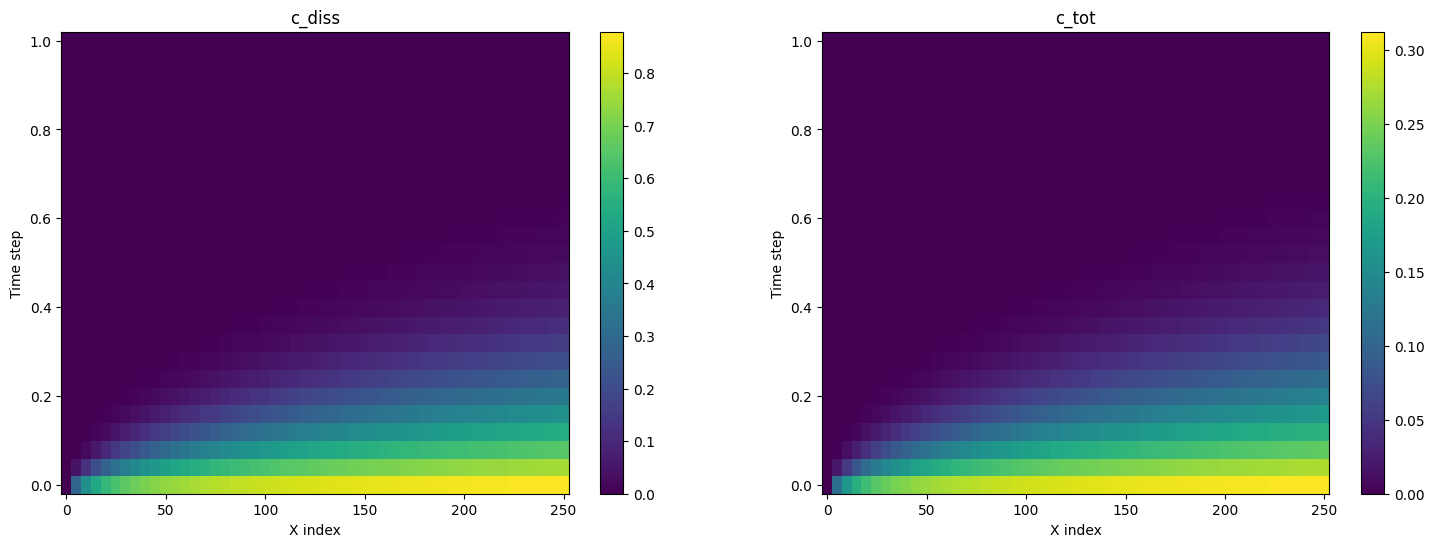

In [27]:
plot_c(t=T, x=X, c=c_train[...,0])